#### Import modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import modules.peaks as px
import modules.fouriertransform as ft
import modules.correlationfunctions as cf
import modules.gaussianfield as grf
import modules.filters as flt
import nbodykit.lab as nbkt
import scipy.interpolate as interpolate
import scipy.signal as signal
import scipy.stats as stats

# Gaussian fields

## Set Parameters

In [ ]:
N = 256 # Number of particles per side 
BoxSize = 512.0 # Size per side (Mpc)
dx = BoxSize/N
h = 0.695 # Reduced Hubble constant
k0 = 0.02 # Pivot mode
A0 = (7.96*10**-10) # Amplitude
ns = 0.965 # Spectral index
dk = (2*np.pi) / BoxSize # Bin size (for power spectrum)

seed = 13579

Pk = lambda k: A0 * (k/k0)**(ns-1) * k**-3 # Power spectrum

## Generate Gaussian field

To generate a Gaussian random field with a given power spectrum $P(k)$, we can just compute $f_{\mathbf{k}} = \sum \hat a_{\mathbf{k}} \sqrt{P(k)} e^{-i\mathbf{k}.\mathbf{x}}$ where $\hat a_{\mathbf{k}}$ is a Gaussian deviate, and inverse-Fourier transform it.


In [ ]:
# Using nbodykit

mesh = nbkt.LinearMesh(Plin=Pk, Nmesh=N, BoxSize=BoxSize, seed=seed)
g = mesh.preview() - 1 # WHY DO WE SUBTRACT 1??

# Extracting a random 1D realization of the 3D field
g1D = g[0][0]

In [ ]:
# Using gaussianfield

g = grf.gaussian_random_field_1D(N, BoxSize=N, seed=seed)

## Plot a slice of a field

In [ ]:
# Here, we're plotting the random 1D field fluctuations
plt.figure(figsize=(8, 4))
plt.title(r'$\zeta_G$')
plt.plot(g, label=r'$\zeta_G$')
plt.xlabel(r'Position ($z$)')
plt.ylabel(r'Fluctuation Size ($\times 10^{-5}$)')

print(np.var(g))

# x=15
# plt.figure(figsize=(5, 4))
# plt.title(r'$\zeta_G$, Slice $x = $' + str(x))
# plt.imshow(10**5*g[x].real, interpolation='none', cmap='plasma', vmin=-4.5, vmax=4.5)
# plt.colorbar(fraction=0.046, pad=0.04).ax.set_title(r'$\times 10^{-5}$', fontsize=9)


# Uncorrelated peaks and statistics



## Peaks functions
The peaks we consider here have a shape defined by the function $\texttt{profile}$ in $\texttt{peaks.py}$. For a Gaussian profile: $$P_p (\mathbf{x}) = \frac{Z_p}{(2 \pi R_p^2)^{3/2}} e^{-\frac{\| \mathbf{x} \| ^2}{2R_p^2}}.$$

The (uncorrelated) non-Gaussian field is then: $$\zeta (\mathbf{x}) = \zeta_G (\mathbf{x}) + \sum_{p=1}^{N_{peaks}} P_p (\mathbf{x} - \mathbf{x_p}).$$

We choose a number $N_{peaks}$, uniformly draw, using  the function $\texttt{draw\_peaks}$, $N_{peaks}$ positions on the grid for the peaks, and add their contribution to the Gaussian field.

## Add peaks
Add $\texttt{nop}$ peaks of size $\texttt{R}$ and amplitude $\texttt{zp}$ to the Gaussian realization $\texttt{g}$. 

In [ ]:
nop = 50
zp = 25e-5
r = 8

# u_peaks is a list [[x, y, z], zp, rp], where xp is the location of the 
# peak/dip, zp its height and rp its width
u_peaks = px.draw_peaks(nop, N, zp, r)

# add_peaks adds the peaks to the field 'g' where 'N' is the size of the field
# in particles per side
ng = px.add_peaks(g, u_peaks, N) 

## Plot slices

In [ ]:
# u_peaks should have 'nop' peaks (so 'nop' entries) that are distributed randomly in the 3D field.
# We want to isolate a 1D portion of the field that has a peak.

# We choose a random peak using 'p', and look for its 'x' and 'y' coordinates in u_peaks
p = 19 # number of the peak
x = u_peaks[p][0][0]
y = u_peaks[p][0][1]
print(x, y)
print(u_peaks[p])

In [ ]:
# Here, we plot 1D field with peaks at coordinates (x, y) 
plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.title(r'$\zeta_G$')
plt.plot(10**5*g[x][y].real, label=r'$\zeta_G$')
plt.xlabel(r'Position ($x$)')
plt.ylabel(r'Fluctuation Size ($\times 10^{-5}$)')

plt.subplot(122)
plt.title(r'$\zeta_{NG}$')
plt.plot(10**5*ng[x][y].real, label=r'$\zeta_G$')
plt.xlabel(r'Position ($x$)')
plt.ylabel(r'Fluctuation Size ($\times 10^{-5}$)')

# plt.subplot(121)
# plt.title(r'$\zeta_G$, Slice $x = $' + str(x))
# plt.imshow(10**5*g[x].real, interpolation='none', cmap='plasma', vmin=-4.5, vmax=4.5)
# plt.colorbar(fraction=0.046, pad=0.04).ax.set_title(r'$\times 10^{-5}$', fontsize=9)

# plt.subplot(122)
# plt.title(r'$\zeta_{NG}$, Slice $x = $' + str(x))
# plt.imshow(10**5*ng[x].real, interpolation='none', cmap='plasma', vmin=-4.5, vmax=4.5)
# plt.colorbar(fraction=0.046, pad=0.04).ax.set_title(r'$\times 10^{-5}$', fontsize=9)

## Plot power spectrum

In [ ]:
# Using nbodykit

mesh_zeta_G = nbkt.ArrayMesh(g, BoxSize=BoxSize)
r_zeta_G = nbkt.FFTPower(mesh_zeta_G, mode='1d', dk=dk)
power_G = r_zeta_G.power
print(type(mesh_zeta_G))

mesh_zeta_NG = nbkt.ArrayMesh(ng, BoxSize=BoxSize)
r_zeta_NG = nbkt.FFTPower(mesh_zeta_NG, mode='1d', dk=dk)
power_NG = r_zeta_NG.power

k = power_G['k']

plt.figure(figsize=(8, 4))
plt.loglog(k, k**(4-ns)*power_G['power'], label=r'$\zeta_G$')
plt.loglog(k, k**(4-ns)*power_NG['power'], label=r'$\zeta_{NG}$')
plt.legend(loc='upper right')
plt.xlabel(r'$k$ $[Mpc^{-1}]$')
plt.ylabel(r'$k^{4-n_s}P(k)$')

In [ ]:
fft_G1D = np.fft.fft(g[x][y])
conj_fft_G1D = fft_G1D.conjugate()
power_G1D = np.multiply(fft_G1D,conj_fft_G1D)
k = ft.fftmodes(N)

fft_nG1D = np.fft.fft(ng[x][y])
conj_fft_nG1D = fft_nG1D.conjugate()
power_nG1D = np.multiply(fft_nG1D,conj_fft_nG1D)

plt.figure(figsize=(8, 4))
plt.loglog(2*k*np.pi, k**(4)*power_G1D, label=r'$\zeta_G$')
plt.loglog(2*k*np.pi, k**(4)*power_nG1D, label=r'$\zeta_{NG}$')
plt.legend(loc='upper right')
plt.xlabel(r'$k$ $[Mpc^{-1}]$')
plt.ylabel(r'$k^{4-n_s}P(k)$')

In [ ]:
# Using correlationfunction module

pg, k = cf.power_spectrum(g[x][y], BoxSize=BoxSize, oneD=True)
png, k = cf.power_spectrum(ng[x][y], BoxSize=BoxSize, oneD=True)

pg = pg[k<.5*(N/BoxSize)] # Select modes bellow the Nyquist frequency
png = png[k<.5*(N/BoxSize)]
k = k[k<.5*(N/BoxSize)]

plt.figure(figsize=(8, 4))
plt.loglog(2*k*np.pi, k**(4-ns)*pg, label=r'$\zeta_G$')
plt.loglog(2*k*np.pi, k**(4-ns)*png, label=r'$\zeta_{NG}$')
plt.legend(loc='upper right')
plt.xlabel(r'$k$ $[Mpc^{-1}]$')
plt.ylabel(r'$k^{4-n_s}P(k)$')

## Plot CDF and PDF

In [ ]:
# Plot CDF
s = g.std()
xg, cdfg = cf.cdf(g)
xng, cdfng = cf.cdf(ng)

plt.figure(figsize=(8, 4))

plt.plot(xg/s, cdfg, label=r'$\zeta_G$') #in units of the standard deviation in the x-axis
plt.plot(xng/s, cdfng, label=r'$\zeta_{NG}$') #in units of the standard deviation in the x-axis
plt.legend(loc='upper left')
plt.xlim((-3.0, 3.0))

In [ ]:
# Plot PDF
s = g.std()
yg, pdfg = cf.pdf(g)                                                                                                                                                                                                                                                                                               
yng, pdfng = cf.pdf(ng)


plt.figure(figsize=(8, 4))

plt.plot(yg/s, pdfg, label=r'$\zeta_G$')
plt.plot(yng/s, pdfng, label=r'$\zeta_{NG}$')
plt.legend(loc='upper left')
plt.xlim((-3.0, 3.0))

## Vary parameters of peaks



In [ ]:
# Variation of the radius r for fixed nop and zp
s = g.std()

R = [2, 4, 8, 12]
nop = 5
zp = 25e-5

c = len(R)



plt.figure(figsize=(8, 4))

pg, k = cf.power_spectrum(g, BoxSize=BoxSize)
pg = pg[k<.5*(N/BoxSize)]
k = k[k<.5*(N/BoxSize)]
plt.loglog(k, pg*k**(4-ns), label=r'$\zeta_G$')

for i in range(c):
    u_peaks = px.draw_peaks(nop, N, zp, R[i])
    ng = px.add_peaks(g, u_peaks, N)
    
    png, k = cf.power_spectrum(ng, BoxSize=BoxSize)
    png = png[k<.5*(N/BoxSize)]
    k = k[k<.5*(N/BoxSize)]
    plt.loglog(k, png * k ** (4-ns), '--', label=r'$\zeta_{NG} ; R_p = $' + str(R[i]))

plt.xlabel(r'$k/2\pi$')
plt.ylabel(r'$k^{4-n_s}P(k)$')
plt.legend(loc='upper right')

plt.tight_layout()

In [ ]:
# Variation of the number of peaks nop for fixed r and zp

Np = [5, 10, 20, 50, 100]
zp = 10e-5
rp = 8

np = len(Np)

plt.figure(figsize=(8, 4))

pg, k = cf.power_spectrum(g, BoxSize=BoxSize)
pg = pg[k<.5*(N/BoxSize)]
k = k[k<.5*(N/BoxSize)]
plt.loglog(k, pg* k ** (4-ns), label=r'$\zeta_G$')

for i in range(np):
    u_peaks = px.draw_peaks(Np[i], N, zp, rp)
    ng = px.add_peaks(g, u_peaks, N)
    
    png, k = cf.power_spectrum(ng, BoxSize=BoxSize)
    png = png[k<.5*(N/BoxSize)]
    k = k[k<.5*(N/BoxSize)]
    plt.loglog(k, png * k ** (4-ns), '--', label='$\zeta_{NG} ; N_p = $' + str(Np[i]))
    
plt.xlabel(r'$k/2\pi$')
plt.ylabel(r'$k^{4-n_s}P(k)$')
plt.legend(loc='upper right')




plt.tight_layout()

In [ ]:
# Variation of the amplitude zp for fixed r and nop

Z = [ 8.5e-5, 20e-5, 30e-5, 60e-5]
z = len(Z)
nop = 10
rp = 8

plt.figure(figsize=(8, 4))

pg = pg[k<.5*(N/BoxSize)]
k = k[k<.5*(N/BoxSize)]
plt.loglog(k, pg* k ** (4-ns), label=r'$\zeta_G$')

for i in range(z):
    u_peaks = px.draw_peaks(nop, N, Z[i], rp)
    ng = px.add_peaks(g, u_peaks, N)

    png, k = cf.power_spectrum(ng, BoxSize=BoxSize)
    png = png[k<.5*(N/BoxSize)]
    k = k[k<.5*(N/BoxSize)]
    plt.loglog(k, png * k ** (4-ns), '--', label='$\zeta_{NG} ; N_p = $' + str(Np[i]))

plt.xlabel(r'$k/2\pi$')
plt.ylabel(r'$k^{4-n_s}P(k)$')
plt.legend(loc='upper right')


plt.tight_layout()

# Correlated peaks and statistics

We apply the following functions on the Gaussian field to generate a non-Gaussian field. The plots are in units of the standard deviation of the Gaussian field

In [ ]:
from IPython.display import Image
Image(filename='Plots/fcts.png')

## Set parameters

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import modules.peaks as px
import modules.fouriertransform as ft
import modules.correlationfunctions as cf
import modules.gaussianfield as grf
import modules.filters as flt
import nbodykit.lab as nbkt
import scipy.interpolate as interpolate
import scipy.signal as signal
import scipy.stats as stats

# Generate G fields using gaussianfield

# Parameters
logtwo_N = 20
N = 2**logtwo_N
BoxSize = 512.0
dx = BoxSize/N
h = 0.695
k0 = 0.02 
A0 = (7.96*10**-10)# * 2*np.pi**2)
ns = 0.965
seed = 50
dk = (2*np.pi) / BoxSize # Bin size (for power spectrum)

Pk = lambda k: A0*(k/k0)**(ns-1)*k**-3

# Generate the grfs
g = grf.gaussian_random_field_1D(N, BoxSize=N, seed=seed)
f = grf.gaussian_random_field_1D(N, BoxSize=N, seed=10000)

In [4]:
# Other Parameters

# NG
alpha = 1.0
nu = 2
c, w = 2, .2

## Generate nonG fields

In [5]:
# Generate nonG fields

# Extract the standard deviation of the gaussian fields
s = g.std()
sf = f.std()

# Generate the non-gaussian components that will be added to the gaussian fields
# Note that 'g' is the field used to generate the NG components, so the NG
# is correlated with 'g', and 'f' is a different Gaussian random field with
# which the NG is uncorrelated
NG_symsinh = px.map_sinh(g, nu*s, alpha) - g
NG_asymsinh = px.map_asymm_sinh(g, nu*s, alpha) - g
NG_smooth_bump = px.map_smooth_bump(g, c, w) - g
NG_squared = g**2 - g

# Generate the correlated NG zeta fields 
zeta_NG_symsinh = g + NG_symsinh
zeta_NG_asymsinh = g + NG_asymsinh
zeta_NG_smooth_bump = g + NG_smooth_bump
zeta_NG_squared = g + g**2

# Generate the uncorrelated NG zeta fields 
zeta_NG_symsinh_uncorr = f + NG_symsinh
zeta_NG_asymsinh_uncorr = f + NG_asymsinh
zeta_NG_smooth_bump_uncorr = f + NG_smooth_bump
zeta_NG_squared_uncorr = f + g**2

# Test the asymmetric sinh function applied to a linear function tf
tf = np.linspace(-4, 4, N)
zeta_NG_asymsinh_test = px.map_asymm_sinh(tf, nu*s, alpha) - tf

# Generate gaussian distribution from mean and std of NG zeta fields
# ???

## Why are we getting an error for invalid value in power?

In [ ]:
# Smooth the correlated nonG field and calculate cumulants and moments (1 to 4) in each band

# kc = np.arange(1, N//2+1, step=1000)
# kw = np.ones(np.shape(kc)) * 10
kc = np.logspace(0, logtwo_N-1, num=10, base=2.0)
kc_size = kc.size
fld_g = g
fld_ng = zeta_NG_asymsinh

cum1_g = np.zeros(np.shape(kc))
cum2_g = np.zeros(np.shape(kc))
cum3_g = np.zeros(np.shape(kc))
cum4_g = np.zeros(np.shape(kc))

cum1_ng = np.zeros(np.shape(kc))
cum2_ng = np.zeros(np.shape(kc))
cum3_ng = np.zeros(np.shape(kc))
cum4_ng = np.zeros(np.shape(kc))

cum1_g_ln = np.zeros(np.shape(kc))
cum2_g_ln = np.zeros(np.shape(kc))
cum3_g_ln = np.zeros(np.shape(kc))
cum4_g_ln = np.zeros(np.shape(kc))

cum1_ng_ln = np.zeros(np.shape(kc))
cum2_ng_ln = np.zeros(np.shape(kc))
cum3_ng_ln = np.zeros(np.shape(kc))
cum4_ng_ln = np.zeros(np.shape(kc))

mom1_g = np.zeros(np.shape(kc))
mom2_g = np.zeros(np.shape(kc))
mom3_g = np.zeros(np.shape(kc))
mom4_g = np.zeros(np.shape(kc))

mom1_ng = np.zeros(np.shape(kc))
mom2_ng = np.zeros(np.shape(kc))
mom3_ng = np.zeros(np.shape(kc))
mom4_ng = np.zeros(np.shape(kc))

mom1_g_ln = np.zeros(np.shape(kc))
mom2_g_ln = np.zeros(np.shape(kc))
mom3_g_ln = np.zeros(np.shape(kc))
mom4_g_ln = np.zeros(np.shape(kc))

mom1_ng_ln = np.zeros(np.shape(kc))
mom2_ng_ln = np.zeros(np.shape(kc))
mom3_ng_ln = np.zeros(np.shape(kc))
mom4_ng_ln = np.zeros(np.shape(kc))

zeta_smooth_gauss = np.zeros((kc_size, N))
zeta_smooth = np.zeros((kc_size, N))
zeta_smooth_ln = np.zeros((kc_size, N))

for i in np.arange(0, kc_size-1):

    zeta_smooth_gauss[i] = grf.window(fld_g, N, kc[i], kc[i+1])
    zeta_smooth[i] = grf.window(fld_ng, N, kc[i], kc[i+1])
#     zeta_smooth_ln[i], W_inv = grf.window_gauss_ln(zeta_NG_asymsinh, N, k, kw[i])
    
    cum1_ng[i] = stats.kstat(zeta_smooth[i], n=1)
    cum1_g[i] = stats.kstat(zeta_smooth_gauss[i], n=1)
    mom1_ng[i] = stats.moment(zeta_smooth[i], moment=1)
    mom1_g[i] = stats.moment(zeta_smooth_gauss[i], moment=1)
    
    cum2_ng[i] = stats.kstat(zeta_smooth[i], n=2)
    cum2_g[i] = stats.kstat(zeta_smooth_gauss[i], n=2)
    mom2_ng[i] = stats.moment(zeta_smooth[i], moment=2)
    mom2_g[i] = stats.moment(zeta_smooth_gauss[i], moment=2)
    
    cum3_ng[i] = stats.kstat(zeta_smooth[i], n=3)
    cum3_g[i] = stats.kstat(zeta_smooth_gauss[i], n=3)
    mom3_ng[i] = stats.moment(zeta_smooth[i], moment=3)
    mom3_g[i] = stats.moment(zeta_smooth_gauss[i], moment=3)
    
    cum4_ng[i] = stats.kstat(zeta_smooth[i], n=4)
    cum4_g[i] = stats.kstat(zeta_smooth_gauss[i], n=4)
    mom4_ng[i] = stats.moment(zeta_smooth[i], moment=4)
    mom4_g[i] = stats.moment(zeta_smooth_gauss[i], moment=4)


In [ ]:
# Plot correlated G field, NG field, and F_nl

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,11))

# fld_g = g
# fld_ng = zeta_NG_asymsinh
fld_xax = np.arange(0,N)
fld_diff = zeta_NG_asymsinh - g

ax1.set_title(r'$\zeta_G$ vs. $\zeta_{NG}$')
ax1.plot(fld_xax, fld_ng, label=r'$\zeta_{NG}$', color='C1')
ax1.plot(fld_xax, fld_g, label=r'$\zeta_G$')
ax1.legend(loc='upper left')
ax1.set(xlabel=r'$x$', ylabel="Amplitude")

ax2.set_title(r'$\zeta_{NG} - \zeta_G$')
ax2.plot(fld_xax, fld_diff, color='C1')
ax2.set(xlabel=r'$x$', ylabel="Amplitude Difference")

ax3.set_title("Asymmetric Sinh "r'$F_{NL}$')
ax3.plot(tf, zeta_NG_asymsinh_test, label=r'$\zeta_{NG}$', color='C2')
ax3.set(xlabel=r'$f$', ylabel=r'$F_{NL}(f)$')

ax4.set_visible(False)

plt.savefig('CorrNG_Fields.png')

In [ ]:
# Plot PDFs for correlated G and NG fields

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,11))

# fld_g = g
# fld_ng = zeta_NG_asymsinh
hist_binvalues = np.linspace(-4.5, 4.5, 500)

ax1.set_title(r'PDF $\zeta_G$')
ax1.hist(fld_g, bins=hist_binvalues, density=True, histtype='step')
ax1.set(ylabel="Probability")

ax2.set_title(r'PDF $\zeta_{NG}$')
ax2.hist(fld_ng, bins=hist_binvalues, density=True, histtype='step', color='C1')
ax2.set(ylabel="Probability")

ax3.set_title(r'PDF $\zeta_G$ vs. $\zeta_{NG}$')
ax3.hist(fld_g, bins=hist_binvalues, density=True, label=r'$\zeta_G$', histtype='step')
ax3.hist(fld_ng, bins=hist_binvalues, density=True, label=r'$\zeta_{NG}$', histtype='step', color='C1')
ax3.legend(loc='upper left')
ax3.set(ylabel=r"Probability")

ax4.set_visible(False)

plt.savefig('CorrNG_PDFs.png')

In [ ]:
# Plot cumulants for correlated G and NG fields

fig, axs = plt.subplots(2,2,figsize=(15,11))

# fld_g = g
# fld_ng = zeta_NG_asymsinh
cm_xax = np.log2(kc)
gmark = 'x'
ngmark = 'o'

axs[0, 0].set_title(r'First Cumulant')
axs[0, 0].plot(cm_xax, cum1_g, gmark, label=r'$\zeta_G$')
axs[0, 0].plot(cm_xax, cum1_ng, ngmark, label=r'$\zeta_{NG}$')
axs[0, 0].legend(loc='best')

axs[0, 1].set_title(r'Second Cumulant')
axs[0, 1].plot(cm_xax, cum2_g, gmark, label=r'$\zeta_G$')
axs[0, 1].plot(cm_xax, cum2_ng, ngmark, label=r'$\zeta_{NG}$')
axs[0, 1].legend(loc='best')

axs[1, 0].set_title(r'Third Cumulant')
axs[1, 0].plot(cm_xax, cum3_g, gmark, label=r'$\zeta_G$')
axs[1, 0].plot(cm_xax, cum3_ng, ngmark, label=r'$\zeta_{NG}$')
axs[1, 0].legend(loc='best')

axs[1, 1].set_title(r'Fourth Cumulant')
axs[1, 1].plot(cm_xax, cum4_g, gmark, label=r'$\zeta_G$')
axs[1, 1].plot(cm_xax, cum4_ng, ngmark, label=r'$\zeta_{NG}$')
axs[1, 1].legend(loc='best')

k = 1
for ax in axs.flat:
    ax.set(xlabel=r'$log_{2}(k)$', ylabel=r'$\kappa_{{{0}}}$'.format(k))
    k += 1
    
plt.savefig('CorrNG_cum.png')

In [ ]:
# Plot moments for correlated G and NG fields

fig, axs = plt.subplots(2,2,figsize=(15,11))

# fld_g = g
# fld_ng = zeta_NG_asymsinh
cm_xax = np.log2(kc)
gmark = 'x'
ngmark = 'o'

axs[0, 0].set_title(r'First Moment')
axs[0, 0].plot(cm_xax, mom1_g, gmark, label=r'$\zeta_G$')
axs[0, 0].plot(cm_xax, mom1_ng, ngmark, label=r'$\zeta_{NG}$')
axs[0, 0].legend(loc='best')

axs[0, 1].set_title(r'Second Moment')
axs[0, 1].plot(cm_xax, mom2_g, gmark, label=r'$\zeta_G$')
axs[0, 1].plot(cm_xax, mom2_ng, ngmark, label=r'$\zeta_{NG}$')
axs[0, 1].legend(loc='best')

axs[1, 0].set_title(r'Third Moment')
axs[1, 0].plot(cm_xax, mom3_g, gmark, label=r'$\zeta_G$')
axs[1, 0].plot(cm_xax, mom3_ng, ngmark, label=r'$\zeta_{NG}$')
axs[1, 0].legend(loc='best')

axs[1, 1].set_title(r'Fourth Moment')
axs[1, 1].plot(cm_xax, mom4_g, gmark, label=r'$\zeta_G$')
axs[1, 1].plot(cm_xax, mom4_ng, ngmark, label=r'$\zeta_{NG}$')
axs[1, 1].legend(loc='best')

k = 1
for ax in axs.flat:
    ax.set(xlabel=r'$log_{2}(k)$', ylabel=r'$\mu_{{{0}}}$'.format(k))
    k += 1
    
plt.savefig('CorrNG_mom.png')

In [ ]:
# Smooth the uncorrelated nonG field and calculate cumulants and moments (1 to 4) in each band

# kc = np.arange(1, N//2+1, step=1000)
# kw = np.ones(np.shape(kc)) * 10
kc = np.logspace(0, logtwo_N-1, num=10, base=2.0)
kc_size = kc.size
fld_g = f
fld_ng = zeta_NG_asymsinh_uncorr

cum1_g = np.zeros(np.shape(kc))
cum2_g = np.zeros(np.shape(kc))
cum3_g = np.zeros(np.shape(kc))
cum4_g = np.zeros(np.shape(kc))

cum1_ng = np.zeros(np.shape(kc))
cum2_ng = np.zeros(np.shape(kc))
cum3_ng = np.zeros(np.shape(kc))
cum4_ng = np.zeros(np.shape(kc))

cum1_g_ln = np.zeros(np.shape(kc))
cum2_g_ln = np.zeros(np.shape(kc))
cum3_g_ln = np.zeros(np.shape(kc))
cum4_g_ln = np.zeros(np.shape(kc))

cum1_ng_ln = np.zeros(np.shape(kc))
cum2_ng_ln = np.zeros(np.shape(kc))
cum3_ng_ln = np.zeros(np.shape(kc))
cum4_ng_ln = np.zeros(np.shape(kc))

mom1_g = np.zeros(np.shape(kc))
mom2_g = np.zeros(np.shape(kc))
mom3_g = np.zeros(np.shape(kc))
mom4_g = np.zeros(np.shape(kc))

mom1_ng = np.zeros(np.shape(kc))
mom2_ng = np.zeros(np.shape(kc))
mom3_ng = np.zeros(np.shape(kc))
mom4_ng = np.zeros(np.shape(kc))

mom1_g_ln = np.zeros(np.shape(kc))
mom2_g_ln = np.zeros(np.shape(kc))
mom3_g_ln = np.zeros(np.shape(kc))
mom4_g_ln = np.zeros(np.shape(kc))

mom1_ng_ln = np.zeros(np.shape(kc))
mom2_ng_ln = np.zeros(np.shape(kc))
mom3_ng_ln = np.zeros(np.shape(kc))
mom4_ng_ln = np.zeros(np.shape(kc))

zeta_smooth_gauss = np.zeros((kc_size, N))
zeta_smooth = np.zeros((kc_size, N))
zeta_smooth_ln = np.zeros((kc_size, N))

for i in np.arange(0, kc_size-1):

    zeta_smooth_gauss[i] = grf.window(fld_g, N, kc[i], kc[i+1])
    zeta_smooth[i] = grf.window(fld_ng, N, kc[i], kc[i+1])
#     zeta_smooth_ln[i], W_inv = grf.window_gauss_ln(zeta_NG_asymsinh, N, k, kw[i])
    
    cum1_ng[i] = stats.kstat(zeta_smooth[i], n=1)
    cum1_g[i] = stats.kstat(zeta_smooth_gauss[i], n=1)
    mom1_ng[i] = stats.moment(zeta_smooth[i], moment=1)
    mom1_g[i] = stats.moment(zeta_smooth_gauss[i], moment=1)
    
    cum2_ng[i] = stats.kstat(zeta_smooth[i], n=2)
    cum2_g[i] = stats.kstat(zeta_smooth_gauss[i], n=2)
    mom2_ng[i] = stats.moment(zeta_smooth[i], moment=2)
    mom2_g[i] = stats.moment(zeta_smooth_gauss[i], moment=2)
    
    cum3_ng[i] = stats.kstat(zeta_smooth[i], n=3)
    cum3_g[i] = stats.kstat(zeta_smooth_gauss[i], n=3)
    mom3_ng[i] = stats.moment(zeta_smooth[i], moment=3)
    mom3_g[i] = stats.moment(zeta_smooth_gauss[i], moment=3)
    
    cum4_ng[i] = stats.kstat(zeta_smooth[i], n=4)
    cum4_g[i] = stats.kstat(zeta_smooth_gauss[i], n=4)
    mom4_ng[i] = stats.moment(zeta_smooth[i], moment=4)
    mom4_g[i] = stats.moment(zeta_smooth_gauss[i], moment=4)



In [ ]:
# Plot uncorrelated G field, NG field, and F_nl

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,11))

# fld_g = g
# fld_ng = zeta_NG_asymsinh
fld_xax = np.arange(0,N)
fld_diff = zeta_NG_asymsinh - g
transp = 0.4

ax1.set_title(r'$\zeta_G$ vs. $\zeta_{NG}$')
ax1.plot(fld_xax, fld_g, label=r'$\zeta_G$')
ax1.plot(fld_xax, fld_ng, label=r'$\zeta_{NG}$', alpha = transp, color='C1')
ax1.legend(loc='upper left')
ax1.set(xlabel=r'$x$', ylabel="Amplitude")

ax2.set_title(r'$\zeta_{NG} - \zeta_G$')
ax2.plot(fld_xax, fld_diff, color='C1')
ax2.set(xlabel=r'$x$', ylabel="Amplitude Difference")

ax3.set_title("Asymmetric Sinh "r'$F_{NL}$')
ax3.plot(tf, zeta_NG_asymsinh_test, label=r'$\zeta_{NG}$', color='C2')
ax3.set(xlabel=r'$f$', ylabel=r'$F_{NL}(f)$')

ax4.set_visible(False)

plt.savefig('UncorrNG_Fields.png')

In [ ]:
# Plot PDFs for uncorrelated G and NG fields

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,11))

# fld_g = g
# fld_ng = zeta_NG_asymsinh
hist_binvalues = np.linspace(-4.5, 4.5, 500)

ax1.set_title(r'PDF $\zeta_G$')
ax1.hist(fld_g, bins=hist_binvalues, density=True, histtype='step')
ax1.set(ylabel="Probability")

ax2.set_title(r'PDF $\zeta_{NG}$')
ax2.hist(fld_ng, bins=hist_binvalues, density=True, histtype='step', color='C1')
ax2.set(ylabel="Probability")

ax3.set_title(r'PDF $\zeta_G$ vs. $\zeta_{NG}$')
ax3.hist(fld_g, bins=hist_binvalues, density=True, label=r'$\zeta_G$', histtype='step')
ax3.hist(fld_ng, bins=hist_binvalues, density=True, label=r'$\zeta_{NG}$', histtype='step', color='C1')
ax3.legend(loc='upper left')
ax3.set(ylabel=r"Probability")

ax4.set_visible(False)

plt.savefig('UncorrNG_PDFs.png')

In [ ]:
# Plot cumulants for uncorrelated G and NG fields

fig, axs = plt.subplots(2,2,figsize=(15,11))

# fld_g = g
# fld_ng = zeta_NG_asymsinh
cm_xax = np.log2(kc)
gmark = 'x'
ngmark = 'o'

axs[0, 0].set_title(r'First Cumulant')
axs[0, 0].plot(cm_xax, cum1_g, gmark, label=r'$\zeta_G$')
axs[0, 0].plot(cm_xax, cum1_ng, ngmark, label=r'$\zeta_{NG}$')
axs[0, 0].legend(loc='best')

axs[0, 1].set_title(r'Second Cumulant')
axs[0, 1].plot(cm_xax, cum2_g, gmark, label=r'$\zeta_G$')
axs[0, 1].plot(cm_xax, cum2_ng, ngmark, label=r'$\zeta_{NG}$')
axs[0, 1].legend(loc='best')

axs[1, 0].set_title(r'Third Cumulant')
axs[1, 0].plot(cm_xax, cum3_g, gmark, label=r'$\zeta_G$')
axs[1, 0].plot(cm_xax, cum3_ng, ngmark, label=r'$\zeta_{NG}$')
axs[1, 0].legend(loc='best')

axs[1, 1].set_title(r'Fourth Cumulant')
axs[1, 1].plot(cm_xax, cum4_g, gmark, label=r'$\zeta_G$')
axs[1, 1].plot(cm_xax, cum4_ng, ngmark, label=r'$\zeta_{NG}$')
axs[1, 1].legend(loc='best')

k = 1
for ax in axs.flat:
    ax.set(xlabel=r'$log_{2}(k)$', ylabel=r'$\kappa_{{{0}}}$'.format(k))
    k += 1
    
plt.savefig('UncorrNG_cum.png')

In [ ]:
# Plot moments for uncorrelated G and NG fields

fig, axs = plt.subplots(2,2,figsize=(15,11))

# fld_g = g
# fld_ng = zeta_NG_asymsinh
cm_xax = np.log2(kc)
gmark = 'x'
ngmark = 'o'

axs[0, 0].set_title(r'First Moment')
axs[0, 0].plot(cm_xax, mom1_g, gmark, label=r'$\zeta_G$')
axs[0, 0].plot(cm_xax, mom1_ng, ngmark, label=r'$\zeta_{NG}$')
axs[0, 0].legend(loc='best')

axs[0, 1].set_title(r'Second Moment')
axs[0, 1].plot(cm_xax, mom2_g, gmark, label=r'$\zeta_G$')
axs[0, 1].plot(cm_xax, mom2_ng, ngmark, label=r'$\zeta_{NG}$')
axs[0, 1].legend(loc='best')

axs[1, 0].set_title(r'Third Moment')
axs[1, 0].plot(cm_xax, mom3_g, gmark, label=r'$\zeta_G$')
axs[1, 0].plot(cm_xax, mom3_ng, ngmark, label=r'$\zeta_{NG}$')
axs[1, 0].legend(loc='best')

axs[1, 1].set_title(r'Fourth Moment')
axs[1, 1].plot(cm_xax, mom4_g, gmark, label=r'$\zeta_G$')
axs[1, 1].plot(cm_xax, mom4_ng, ngmark, label=r'$\zeta_{NG}$')
axs[1, 1].legend(loc='best')

k = 1
for ax in axs.flat:
    ax.set(xlabel=r'$log_{2}(k)$', ylabel=r'$\mu_{{{0}}}$'.format(k))
    k += 1
    
plt.savefig('UncorrNG_mom.png')

In [ ]:
# # Plot fields

# # Here, we're plotting the random 1D field fluctuations
# plt.figure(figsize=(14, 10))

# plt.subplot(221)
# plt.title(r'$\zeta_G$')
# plt.plot(g, label=r'$\zeta_G$')
# plt.xlabel(r'Position ($x$)')
# plt.ylabel(r'Fluctuation Size ($\times 10^{-5}$)')

# plt.subplot(222)
# plt.title(r'$\zeta_{NG}$')
# plt.plot(f, label=r'$\zeta_G$')
# plt.xlabel(r'Position ($x$)')
# plt.ylabel(r'Fluctuation Size ($\times 10^{-5}$)')

# plt.subplot(223)
# plt.title(r'$\zeta_{NG}$')
# plt.plot(zeta_NG_squared, label=r'$\zeta_G$')
# plt.xlabel(r'Position ($x$)')
# plt.ylabel(r'Fluctuation Size ($\times 10^{-5}$)')

# plt.subplot(224)
# plt.title(r'$\zeta_{NG}$')
# plt.plot(zeta_NG_gauss, label=r'$\zeta_G$')
# plt.xlabel(r'Position ($x$)')
# plt.ylabel(r'Fluctuation Size ($\times 10^{-5}$)')


## Power spectrum

In [ ]:
# Using nbodykit

dk = 0.01
kmin = 0.01

# Gaussian

mesh_zeta_G = nbkt.ArrayMesh(g, BoxSize=BoxSize)
r_zeta_G = nbkt.FFTPower(mesh_zeta_G, mode='1d', dk=dk, kmin=kmin)
power_G = r_zeta_G.power

# Sinh nonG

mesh_zeta_NG_symsinh = nbkt.ArrayMesh(zeta_NG_symsinh, BoxSize=BoxSize)
r_zeta_NG_symsinh = nbkt.FFTPower(mesh_zeta_NG_symsinh, mode='1d', dk=dk, kmin=kmin)
power_NG_symsinh = r_zeta_NG_symsinh.power

# Asymmetric sinh nonG

mesh_zeta_NG_asymsinh = nbkt.ArrayMesh(zeta_NG_asymsinh, BoxSize=BoxSize)
r_zeta_NG_asymsinh = nbkt.FFTPower(mesh_zeta_NG_asymsinh, mode='1d', dk=dk, kmin=kmin)
power_NG_asymsinh = r_zeta_NG_asymsinh.power

# PDF smooth bump nonG

mesh_zeta_NG_smooth_bump = nbkt.ArrayMesh(zeta_NG_smooth_bump, BoxSize=BoxSize)
r_zeta_NG_smooth_bump = nbkt.FFTPower(mesh_zeta_NG_smooth_bump, mode='1d', dk=dk, kmin=kmin)
power_NG_smooth_bump = r_zeta_NG_smooth_bump.power


# Plot power spectra

k = power_G['k']
plt.loglog(k, k**(4-ns)*power_G['power'].real, '-', label='G')
plt.loglog(k, k**(4-ns)*power_NG_symsinh['power'].real, '*-', label='Sinh nG')
plt.loglog(k, k**(4-ns)*power_NG_asymsinh['power'].real, '.-', label='Asymmetic sinh nG')
plt.loglog(k, k**(4-ns)*power_NG_smooth_bump['power'].real, '--', label='PDF smooth bump nG')

plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$k^{4-n_s}P(k)$ [Mpc$^{-3}$]')
plt.legend(loc='upper left')


# Independent Component Analysis

$\texttt{sklearn}$ module contains contains a $\texttt{FastICA}$ capability. We can chose the cost function (measure of non-Gaussianity): $\texttt{cube}$ for kurtosis, and $\texttt{logcosh}$ for negentropy approximation.



In [6]:
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt
import modules.colorednoise as cn

In [7]:
# Note that 'g' is the field used to generate the NG component called 'NG_asymsinh', 
# so 'NG_asymsinh' is correlated with 'g', and 'f' is a different Gaussian random 
# field with which the 'NG_asymsinh' is uncorrelated. 

source_components = np.vstack([g, NG_asymsinh])
num_comps = 2
num_samples = 400

mix_matrix = (1+np.random.random((num_samples,num_comps)))/2.0
mix_signal = np.dot(mix_matrix, source_components)


In [8]:
# print(fi)
# print(mix.shape, fi.shape)
# print(mix.T)
# print(mix)
print(mix_signal.shape)

(400, 1048576)


## Plot the sources

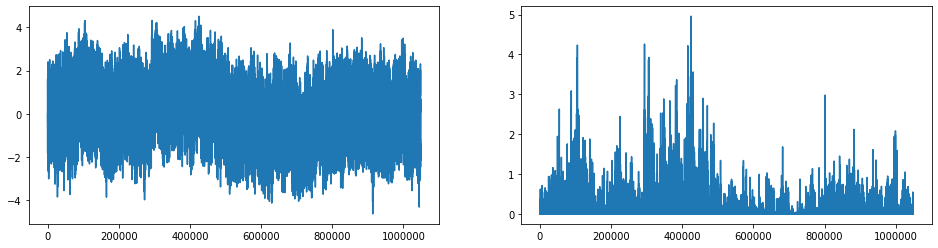

In [9]:
plt.figure(1, figsize=(25,4))

plt.subplot(131)
plt.plot(source_components[0, :])
plt.subplot(132)
plt.plot(source_components[1, :])

## Plot the inputs

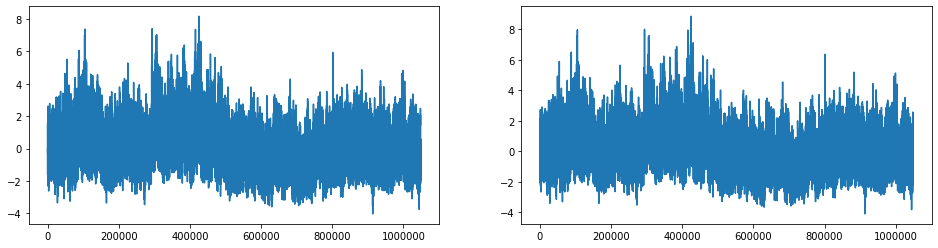

In [11]:
plt.figure(1, figsize=(25,4))

plt.subplot(131)
plt.plot(mix_signal[0, :])
plt.subplot(132)
plt.plot(mix_signal[256, :])

## Apply $\texttt{FastICA}$

In [ ]:
ica = FastICA(n_components=num_comps, algorithm='deflation', max_iter=10, tol=1e-4, fun='cube')
sc = ica.fit_transform(mix_signal.T)
print(sc)

ica = FastICA(n_components=num_comps, algorithm='deflation', max_iter=10, tol=1e-4, fun='logcosh')
sl = ica.fit_transform(mix_signal.T)

## Plot extracted signals

Text(0.5, 1.0, 'Kurtosis')

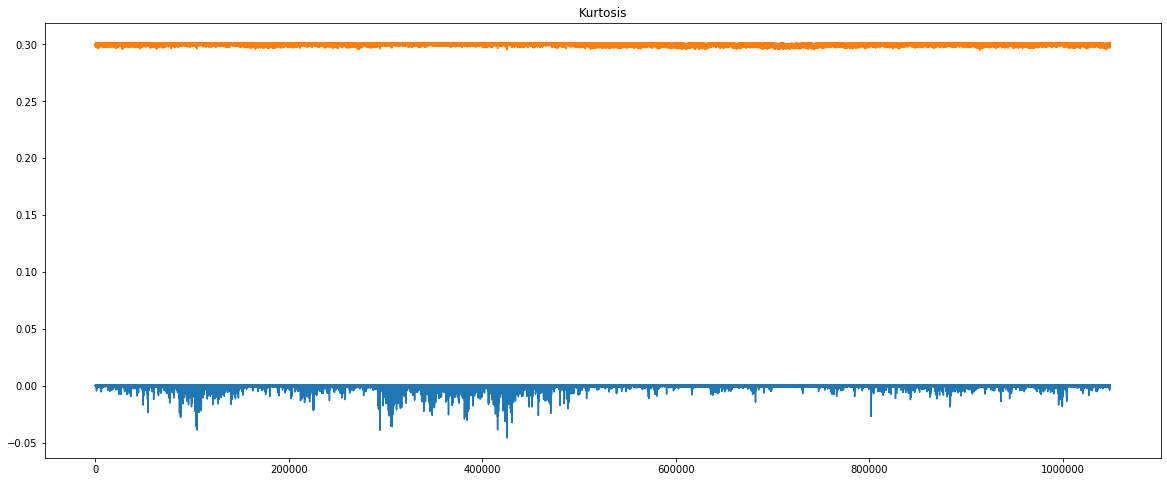

In [17]:
plt.figure(1, figsize=(20,8))

for i in range(2):
    plt.plot(sc[:, i]+.3*i)
    
plt.title('Kurtosis')

Text(0.5, 1.0, 'Negentropy')

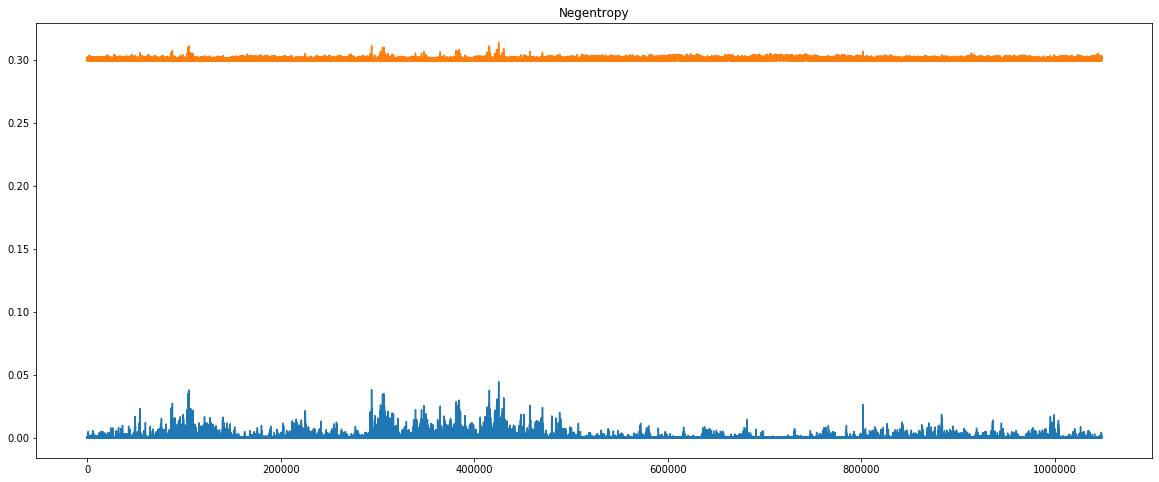

In [18]:
plt.figure(1, figsize=(20,8))

for i in range(2):
    plt.plot(sl[:,i]+.3*i)

plt.title('Negentropy')